# Actor-Critic

REINFORCE에서와 같이 **episodic reward**를 reward function으로 설정하자. 정책 $\pi_\theta$에서 reward function $J(\theta)$는 다음과 같이 정의된다.

$$ J(\theta) = \mathbb{E}_{S_0 \sim d_0, \pi_\theta}\left[ \sum_{t=0}^{\infty}{\gamma^t R_{t+1}} \right] = \mathbb{E}_{S_0 \sim d_0, \pi_\theta}\left[ G_0 \right] = \mathbb{E}_{S_0 \sim d_0}\left[ v_{\pi_\theta} (S_0) \right] $$

Policy Gradient Theorem(episodic)에 의하여, 위 식의 그래디언트인 $\nabla_\theta J(\theta)$ 는 다음과 같다.

$$ \nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \left. \sum_{t=0}^{T}{\gamma^t q_{\pi_\theta}(S_t, A_t) \nabla_\theta \log \pi_\theta (A_t \mid S_t)} \right| S_0 \sim d_0 \right]$$

또한, 수학적으로 다음과 같은 성질이 성립한다.

$$ \mathbb{E}_{\pi_\theta} \left[ b \cdot \nabla_\theta \log \pi_\theta (A_t \mid S_t) \right] = 0 $$

이 성질을 사용하면 단순히 $q_{\pi_\theta}(S_t, A_t)$ 를 reward로 사용하는 것이 아닌, 평균을 빼서 더 안정적인 reward를 계산할 수 있다. 그 평균값은 $v_{\pi_\theta}(S_t)$ 이며, 이를 반영한 gradient 식은 다음과 같다.

$$ \nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \left. \sum_{t=0}^{T}{\gamma^t (q_{\pi_\theta}(S_t, A_t) - v_{\pi_\theta}(S_t) ) \nabla_\theta \log \pi_\theta (A_t \mid S_t)} \right| S_0 \sim d_0 \right]$$

$q_{\pi_\theta}(S_t, A_t) = \mathbb{E}_{\pi_\theta}\left[ \left. G_t \right| S_t, A_t \right]$ 이므로 지금과 같은 stochastic 조건 하에서 $q_{\pi_\theta}(S_t, A_t) \approx G_t$ 로 간주할 수 있다. 다만 이 경우에서는 $v_{\pi_\theta}$ 함수를 사용할 수 있으므로 각 시행마다 발생하는 variance를 줄이기 위해 $G_t$ 대신 $G_t \approx R_{t+1} + \gamma v_{\textbf{w}}(S_{t+1})$ 를 사용한다. 또한 일반적으로 $\gamma^t$ 항은 생략한다.

기존의 Monte-Carlo식의 REINFORCE와는 다르게, Actor-Critic에서 업데이트는 매 $t$ 마다 아래처럼 이루어진다.

$$ \delta_t = R_{t+1} + \gamma v_{\textbf{w}}(S_{t+1}) - v_{\textbf{w}}(S_t) $$
$$ \textbf{w} \leftarrow \textbf{w} + \beta \cdot \delta_t \nabla_\textbf{w} v_{\textbf{w}}(S_t) $$
$$ \theta \leftarrow \theta + \alpha \cdot \delta_t \nabla_\theta \log \pi_\theta (A_t \mid S_t) $$

### 패키지 import
의존성 있는 패키지인 ``` numpy ```, ``` tensorflow ```, ``` keras ```를 import해야 한다.  
  
참고: keras는 단독으로 import하지 않고 반드시 ``` import tensorflow.keras as keras ```와 같이 ``` tensorflow ```를 통해 import해야 잠재적인 오류를 예방할 수 있다.  

주어진 모듈을 설치하기 위해서는 `pip install numpy`, `pip install tensorflow`를 실행하자.

In [30]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

### ReplayBuffer 클래스
Replay buffer란 이전의 (S, a, S', R) 순서쌍들을 모아 둔 거대한 테이블을 뜻한다. 강화학습 특성상 환경과 상호작용하기에 시간 순서대로 데이터가 생성되는 즉시 학습시키면 bias가 발생하기 쉽다. 이러한 buffer를 도입함으로써 문제를 해결할 수 있다.  
 
이 class는 다음과 같은 method로 구성된다.
* 생성자
  * ```replay_size``` 변수에 최대 버퍼크기 명시
  * ```input_dims```에 state feature의 dimension 명시
* ```store```을 통해 S, a, S', R 값과 terminate 여부를 저장
* ```sample```을 통해 주어진 개수만큼 random sampling

In [31]:
class ReplayBuffer:
    def __init__(self, replay_size, input_dims):
        self.replay_size = replay_size
        self.mem_counter = 0
        
        self.state = np.zeros((self.replay_size, *input_dims), dtype=np.float32)
        self.next_state = np.zeros((self.replay_size, *input_dims), dtype=np.float32)
        self.action = np.zeros(self.replay_size, dtype=np.int32)
        self.reward = np.zeros(self.replay_size, dtype=np.float32)
        self.terminate = np.zeros(self.replay_size, dtype=np.int32)
    
    def store(self, state, action, reward, next_state, terminate):
        ''' ReplayBuffer에 단일 데이터쌍 저장 '''
        index = self.mem_counter % self.replay_size

        self.state[index]       = state
        self.next_state[index]  = next_state
        self.action[index]      = action
        self.reward[index]      = reward
        self.terminate[index]   = terminate

        self.mem_counter += 1

    def sample(self, batch_size):
        ''' ReplayBuffer에서 batch_size만큼 임의의 데이터 샘플링 '''

        # 아직 replay buffer가 다 차지 않은 경우를 고려해 실제 space_size를 min함수를 이용해 산정
        space_size = min(self.mem_counter, self.replay_size)
        batch = np.random.choice(space_size, batch_size, replace=False)

        state       = self.state[batch]
        next_state  = self.next_state[batch]
        action      = self.action[batch]
        reward      = self.reward[batch]
        terminate   = self.terminate[batch]

        return state, action, reward, next_state, terminate

### Actor & Critic Model Building
* ``` l_rate ```는 학습률을 나타낸다.
* ``` n_actions ```는 tabular action의 개수를 나타낸다.
* ``` input_dims ```는 state의 feature dimension이다.

In [32]:
class ActorNetwork(keras.Model):
    # pi 함수
    def __init__(self, l_rate, n_actions, input_dims):
        super(ActorNetwork, self).__init__()
        self.l_rate     = l_rate
        self.n_actions  = n_actions
        self.input_dims = input_dims

        self.layer1 = keras.layers.Dense(64, activation='relu')
        self.layer2 = keras.layers.Dense(128, activation='relu')
        self.layer3 = keras.layers.Dense(n_actions, activation='softmax')

        self.compile(optimizer=keras.optimizers.Adam(learning_rate=self.l_rate))

    def call(self, inputs):
        mid1 = self.layer1(inputs)
        mid2 = self.layer2(mid1)
        return self.layer3(mid2)

class CriticNetwork(keras.Model):
    # v 함수
    def __init__(self, l_rate, n_actions, input_dims):
        super(CriticNetwork, self).__init__()
        self.l_rate     = l_rate
        self.n_actions  = n_actions
        self.input_dims = input_dims

        self.layer1 = keras.layers.Dense(64, activation='relu')
        self.layer2 = keras.layers.Dense(128, activation='relu')
        self.layer3 = keras.layers.Dense(n_actions)

        self.compile(optimizer=keras.optimizers.Adam(learning_rate=self.l_rate))

    def call(self, inputs):
        mid1 = self.layer1(inputs)
        mid2 = self.layer2(mid1)
        return self.layer3(mid2)

In [37]:
def categoricalSelect(L):
    ''' L[i] 확률로 i를 반환하는 함수. 어떠한 i에도 해당하지 않으면 0 반환. 0 <= sum(L) <= 1인 경우에만 정의됨.'''
    L = list(tf.squeeze(L))
    pick = np.random.random()
    cumul = 0

    for i, pi in enumerate(L):
        if (cumul <= pick < cumul + float(pi)):
            return i
        cumul += pi

    return 0

class ActorCriticAgent:
    def __init__(self,
            input_dims, n_actions,          # 환경 정의
            actor_rate, critic_rate, gamma, # 학습 하이퍼파라미터
            replay_size, batch_size,        # ReplayBuffer 정의
            filename):

        self.read_only = False  # ActorCriticDeploy 클래스에서 True
        self.gamma = gamma

        self.action = [i for i in range(n_actions)]
        self.policy = ActorNetwork(actor_rate, n_actions, input_dims)
        self.value  = CriticNetwork(critic_rate, n_actions, input_dims)

        self.memory = ReplayBuffer(replay_size, input_dims)
        self.batch_size = batch_size

        self.filename = filename  # model 저장용


    def store(self, state, action, reward, next_state, done):
        ''' internal ReplayBuffer에 상태 저장 '''
        if self.read_only:
            raise Exception("DQNDeploy class can only use model, not store.")
            return
        self.memory.store(state, action, reward, next_state, done)

    def choose_action(self, obs):
        ''' 내부 stochastic policy인 `self.policy`를 토대로 action 결정 '''
        state = np.array([obs], dtype=np.float32) # 관찰 결과를 numpy 스타일로 변환 (tf.convert_to_tensor도 ok)
        pr = self.policy(state) # 신경망으로 전달, 확률 pr에 저장
        return categoricalSelect(pr)

    def learn(self):
        if self.read_only:  # 읽기 전용
            raise Exception("ActorCriticDeploy class can only use model, not learn.")
            return
        if self.memory.mem_counter < self.batch_size:   # 충분한 데이터 수집 전까지 학습 x
            return

        states, actions, rewards, next_states, done = \
            self.memory.sample(self.batch_size) # 데이터를 ReplayBuffer에서 샘플링
        
        # tf.GradientTape에서 사용 위한 전처리 과정
        act_list = tf.cast(actions, dtype=tf.int32)             # action의 기록
        episode = act_list.shape[0]
        episode_list = tf.range(episode, dtype=tf.int32) # action이 일어났던 episode의 기록
        act_list, episode_list = tf.reshape(act_list, (episode, 1)), tf.reshape(episode_list, (episode, 1))
        zip_list = tf.concat((episode_list, act_list), axis=1)     # action & episode 텐서의 병합
        gamma = tf.constant(self.gamma, dtype=tf.float32)
        done = tf.cast(done, tf.float32)

        with tf.GradientTape(persistent=True) as tape:  # Gradient를 policy/value에 2회 적용하므로 persistent
            Pr    = self.policy(states)     # n x n, 이걸 n으로 만들어야 함.
            Vthis = self.value(states)
            Vnext = self.value(next_states)

            Pr    = tf.gather_nd(Pr   , zip_list)
            Vthis = tf.gather_nd(Vthis, zip_list)
            Vnext = tf.gather_nd(Vnext, zip_list)
            
            LogPr = tf.math.log(Pr) # pi(a|s)를 추적해 gradient를 씌워야 함
            Delta = rewards + gamma * Vnext * (1 - done) - Vthis

            ActorLoss  = - tf.math.reduce_sum(LogPr * Delta)    # Reinforce와 같은 원리
            CriticLoss = tf.math.reduce_sum(Delta**2) # DeepMind 7강 참조. 결론부터 말하면 Loss는 RMS(v_pi(s) - v_w(s)) = RMS(G_t - v_w(s)) = RMS(delta)

        gradActor  = tape.gradient(ActorLoss, self.policy.trainable_variables)
        gradCritic = tape.gradient(CriticLoss, self.value.trainable_variables)
        del tape    # 사용이 끝난 tape는 Garbage Collector에게 전달

        self.policy.optimizer.apply_gradients(zip(gradActor, self.policy.trainable_variables))
        self.value .optimizer.apply_gradients(zip(gradCritic, self.value.trainable_variables))

    def save_model(self):
        if self.read_only:
            raise Exception("ActorCriticDeploy class can only use model, not save.")
            return

        self.value.save(self.filename + "-value")
        self.policy.save(self.filename + "-policy")
    
    def load_model(self):
        self.value = keras.models.load_model(self.filename + "-value")
        self.policy = keras.models.load_model(self.filename + "-policy")

class ActorCriticDeploy(ActorCriticAgent):
    ''' Model의 학습과 저장은 불가능하고 오직 사용만을 위한 class '''
    def __init__(self, filename):
        self.filename = filename
        self.read_only = True
        self.load_model()

## Model Evaluating

### Gym을 사용한 가상환경 준비
OpenAI에서 제공하는 gym 모듈을 사용해 보자. 이 모듈은 `pip install gym`을 통해 설치할 수 있다.

In [34]:
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

env = gym.make('CartPole-v1')
observation = env.reset()

### Agent 학습
아래의 코드 블록을 실행하면 랜덤하게 초기화된 cartAgent가 강화학습을 시작한다.

In [39]:
cartAgent = ActorCriticAgent(
    input_dims=env.observation_space.shape, 
    actor_rate=0.0003, 
    critic_rate=0.0003, 
    gamma=0.99,
    n_actions=env.action_space.n, 
    replay_size=32,
    batch_size=8,
    filename='cartpole-ac-replay'
)

scores, scores_avg = list(), list()
prgress = tqdm(range(1000))

for episode in prgress:
    # 환경 및 점수 초기화
    score = 0
    obs_this = env.reset()
    done = False

    while not done:
        # Agent가 선택
        action = cartAgent.choose_action(obs_this)
        obs_next, reward, done, info = env.step(action)
        cartAgent.store(obs_this, action, reward, obs_next, done)

        # 보상 저장
        score += reward
        obs_this = obs_next
        # env.render() # 렉 걸릴 경우 제외

        cartAgent.learn()

    scores.append(score) # 점수 기록
    scores_avg.append(np.mean(scores[-30:])) # 이동평균 산출
    prgress.set_description("score {:>3.1f} | recent average score {:>3.1f}"
        .format(scores[-1], scores_avg[-1]))

    if episode % 200 == 0 and episode > 0: # 100 episode마다 모델을 저장
        cartAgent.save_model()

plt.plot(np.arange(len(scores_avg)), np.array(scores_avg)) # 이동평균 점수 그래프 그리기

  0%|          | 0/1000 [00:00<?, ?it/s]

tf.Tensor(
[[-0.07014836  0.05053015]
 [-0.04496381  0.03167167]
 [-0.0944189   0.07007447]
 [-0.02010098  0.01429473]
 [-0.11688532  0.09004559]
 [-0.01882243  0.01534003]
 [-0.00068095  0.00263332]
 [-0.00223432  0.00272717]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[0 1]
 [1 1]
 [2 1]
 [3 0]
 [4 1]
 [5 1]
 [6 1]
 [7 1]], shape=(8, 2), dtype=int32)
tf.Tensor(
[ 0.05053015  0.03167167  0.07007447 -0.02010098  0.09004559  0.01534003
  0.00263332  0.00272717], shape=(8,), dtype=float32)


  0%|          | 0/1000 [00:28<?, ?it/s]


KeyboardInterrupt: Interrupted by user

다음은 학습한 모델을 불러와 실행하는 블록이다.

score 33.0 | recent average score 17.6: 100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


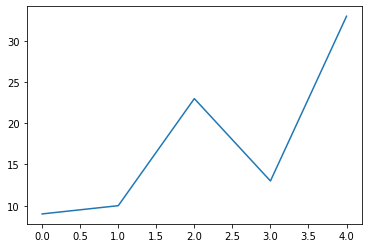

In [14]:
cartDeploy = ActorCriticDeploy('cartpole-ac-replay')

scores, scores_avg = list(), list()
prgress = tqdm(range(5))

for episode in prgress:
    # 환경 및 점수 초기화
    score = 0
    obs_this = env.reset()
    done = False

    while not done:
        # Agent가 선택
        action = cartDeploy.choose_action(obs_this)
        obs_next, reward, done, info = env.step(action)

        # 보상 저장
        score += reward
        obs_this = obs_next
        env.render() # 렉 걸릴 경우 제외

    scores.append(score) # 점수 기록
    scores_avg.append(np.mean(scores[-30:])) # 이동평균 산출
    prgress.set_description("score {:>3.1f} | recent average score {:>3.1f}"
        .format(scores[-1], scores_avg[-1]))

plt.plot(np.arange(len(scores)), np.array(scores)) # 이동평균 점수 그래프 그리기